In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the parent directory to the path to import from src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from src.models import MultivariateForecaster

c:\Users\tiago\OneDrive\Dokumente\GitHub\Energy-Deman-Forecast\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data from silver layer
data_path = '../../data/silver/forecast_data.csv'
df = pd.read_csv(data_path, index_col=0)

# Display the first few rows
display(df.head())

,Client_1,year,hour,is_business_hour,month,day_of_week,is_weekend,hour_sin,hour_cos,day_of_week_sin,...,lag_1,lag_24,diff_1,pct_change_1,diff_24,pct_change_24,rolling_mean_3,rolling_std_3,rolling_mean_7,rolling_std_7
2011-01-01 00:00:00,0.0,2011,0,0,1,5,1,0.000000,1.000000,-0.974928,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2011-01-01 01:00:00,0.0,2011,1,0,1,5,1,0.258819,0.965926,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.0,2011,2,0,1,5,1,0.500000,0.866025,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2011-01-01 03:00:00,0.0,2011,3,0,1,5,1,0.707107,0.707107,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2011-01-01 04:00:00,0.0,2011,4,0,1,5,1,0.866025,0.500000,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [3]:
# Filter the DataFrame to keep only data from June 2012 onwards
df = df[df.index >= '2011-12-01']

# Display the updated DataFrame info
print(f"Data shape after filtering: {df.shape}")
print(f"Date range after filtering: {df.index.min()} to {df.index.max()}")

Data shape after filtering: (27049, 34)
Date range after filtering: 2011-12-01 00:00:00 to 2015-01-01 00:00:00


In [4]:
# Ensure the date column is in datetime format and set it as index
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
elif 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

# Display basic info about the data
print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Available columns: {df.columns.tolist()}")

Data shape: (27049, 34)
Date range: 2011-12-01 00:00:00 to 2015-01-01 00:00:00
Available columns: ['Client_1', 'year', 'hour', 'is_business_hour', 'month', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year', 'week_of_year', 'quarter', 'is_month_start', 'is_month_end', 'time_of_day', 'is_morning', 'is_afternoon', 'is_evening', 'is_night', 'is_holiday', 'lag_1', 'lag_24', 'diff_1', 'pct_change_1', 'diff_24', 'pct_change_24', 'rolling_mean_3', 'rolling_std_3', 'rolling_mean_7', 'rolling_std_7']


In [5]:
# ===============================
# 2. Data Cleaning and Preprocessing
# ===============================

# Check for problematic values in the dataset
print("Checking for problematic values in the dataset:")
print(f"NaN values count: {df.isna().sum().sum()}")

# Safely check for infinity values only in numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns
inf_count = 0
if len(numeric_cols) > 0:
    inf_count = np.isinf(df[numeric_cols]).sum().sum()
print(f"Infinity values count: {inf_count}")

# Get summary statistics to identify potential issues
print("\nData statistics:")
print(df.describe())

# Replace infinity values with NaN (only in numeric columns)
if len(numeric_cols) > 0:
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Define a threshold for extremely large values (adjust based on your domain knowledge)
threshold = 1e9  # Example threshold
large_value_count = 0
if len(numeric_cols) > 0:
    large_value_mask = df[numeric_cols].abs() > threshold
    large_value_count = large_value_mask.sum().sum()
print(f"\nValues larger than {threshold}: {large_value_count}")

if large_value_count > 0:
    # Replace extremely large values with NaN (only in numeric columns)
    for col in numeric_cols:
        df.loc[df[col].abs() > threshold, col] = np.nan
    print("Replaced extremely large values with NaN")

# Handle remaining NaN values - choose an appropriate strategy
# Strategy 1: Forward fill followed by backward fill
df_cleaned = df.fillna(method='ffill').fillna(method='bfill')

# Alternative strategies (uncomment as needed):
# Strategy 2: Replace with column mean
# for col in df.columns:
#     df_cleaned[col] = df[col].fillna(df[col].mean())

# Strategy 3: Drop rows with NaN (may lose data)
# df_cleaned = df.dropna()

# Check if cleaning was successful
print(f"\nNaN values after cleaning: {df_cleaned.isna().sum().sum()}")

# Safely check for infinity values in cleaned dataframe
inf_count_after = 0
numeric_cols_cleaned = df_cleaned.select_dtypes(include=np.number).columns
if len(numeric_cols_cleaned) > 0:
    inf_count_after = np.isinf(df_cleaned[numeric_cols_cleaned]).sum().sum()
print(f"Infinity values after cleaning: {inf_count_after}")

# Use the cleaned dataframe for modeling
df = df_cleaned

# Display updated dataframe info
print(f"\nCleaned data shape: {df.shape}")

Checking for problematic values in the dataset:
NaN values count: 1490
Infinity values count: 99

Data statistics:
           Client_1          year          hour  is_business_hour  \
count  27049.000000  27049.000000  27049.000000      27049.000000   
mean      20.589537   2012.944175     11.499575          0.333321   
std       24.092018      0.869300      6.922540          0.471409   
min        0.000000   2011.000000      0.000000          0.000000   
25%        6.345178   2012.000000      5.000000          0.000000   
50%        8.883249   2013.000000     11.000000          0.000000   
75%       19.035533   2014.000000     17.000000          1.000000   
max      138.324873   2015.000000     23.000000          1.000000   

              month  day_of_week    is_weekend      hour_sin      hour_cos  \
count  27049.000000      27049.0  27049.000000  2.704900e+04  2.704900e+04   
mean       6.672372          3.0      0.285704 -1.388959e-17  3.696994e-05   
std        3.517421          

c:\Users\tiago\OneDrive\Dokumente\GitHub\Energy-Deman-Forecast\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\tiago\OneDrive\Dokumente\GitHub\Energy-Deman-Forecast\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\tiago\AppData\Local\Temp\ipykernel_13472\3609855056.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned = df.fillna(method='ffill').fillna(method='bfill')


In [6]:
# ===============================
# 3. Initialize and Optimize Forecaster
# ===============================

# Set parameters for the forecaster
initial_window = 8760  # One full year of hourly data to capture all seasonal patterns
step_length = 168*30     # One week of data (24 hours × 7 days) for regular model updates
forecast_horizon = np.arange(1, 25*7)  # Forecast horizon of 24 steps (one full day ahead)

# Initialize the forecaster
forecaster = MultivariateForecaster(
    data=df,
    target_columns=["Client_1"],
    config_path="../../config/small_mv_config.json",
    initial_window=initial_window,
    step_length=step_length,
    fh=forecast_horizon
)


🕒 PREPARING DATETIME INDEX
   Converting index to datetime...
✓ Successfully converted to DatetimeIndex


In [ ]:
# Run optimization to find the best model
# This may take some time depending on n_trials
n_trials = 10  # Number of trials for optimization
n_jobs = -1    # Use all available cores

print("Starting model optimization...")
forecast = forecaster.optimize(n_trials=n_trials, n_jobs=n_jobs)
print("Optimization complete!")

# Display the best model parameters
print("Best model parameters:")
best_params = forecaster.study.best_params
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest model performance (RMSE): {forecaster.study.best_value:.4f}")

[I 2025-03-31 20:59:38,262] A new study created in memory with name: no-name-425d5c21-dc98-414f-a703-7aac96665da3


Starting model optimization...


In [ ]:
# ===============================
# 4. Generate and Visualize Forecasts
# ===============================
# Generate forecasts for the next time periods
forecast = forecaster.forecast(forecast_horizon)
print("Forecasts:")
print(forecast)

Forecasts:
                      Client_1
2015-01-01 01:00:00   4.307142
2015-01-01 02:00:00   6.894416
2015-01-01 03:00:00   7.011924
2015-01-01 04:00:00   7.039681
2015-01-01 05:00:00   7.039681
...                        ...
2015-01-08 02:00:00  45.458794
2015-01-08 03:00:00  45.458794
2015-01-08 04:00:00  46.220389
2015-01-08 05:00:00  45.449320
2015-01-08 06:00:00  44.818814

[174 rows x 1 columns]


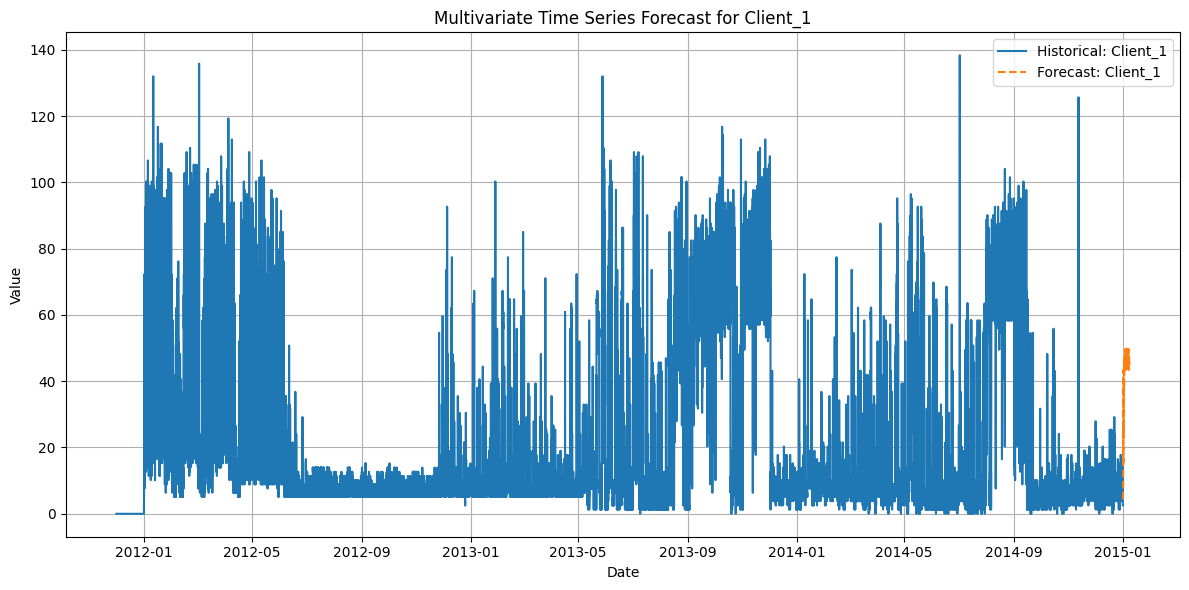

In [ ]:
# Plot the historical data and forecasts for the column 'Client_1'
plt.figure(figsize=(12, 6))

if 'Client_1' in df.columns:
    plt.plot(df.index, df['Client_1'], label='Historical: Client_1')
if 'Client_1' in forecast.columns:
    plt.plot(forecast.index, forecast['Client_1'], label='Forecast: Client_1', linestyle='--')

plt.title('Multivariate Time Series Forecast for Client_1')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ===============================
# 5. Save the Results
# ===============================

# Save the forecasts to a CSV file
output_path = '../../data/gold/multivariate_forecasting_results.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
forecast.to_csv(output_path)
print(f"Forecasts saved to {output_path}")